## Import dependencies

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
from zipfile import ZipFile

from fair import *
from fair.scripts.stats import *
from fair.scripts.data_retrieval import *

%matplotlib inline

### Aerosol parameters following Smith et al. (2020)

Here we base aerosol forcing relations on [Smith et al., 2020](http://www.essoar.org/doi/10.1002/essoar.10503977.1). ERFari is modelled as a linear combination of SO$_2$, BC and OC emissions. For ERFaci we use a combination of a logarithmic SO$_2$ dependence and a linear BC / OC dependence. We reduce the potential number of parameters to avoid overfitting. That is:

$$
ERF_{ari} = \alpha_{SO_2} \cdot E_{SO_2} + \alpha_{BC} \cdot E_{BC} + \alpha_{OC} \cdot E_{OC} \,; \text{and}\\\\
ERF_{aci} = \beta \cdot ln\left(1 + \frac{E_{SO_2}}{s}\right) + \alpha \cdot ( E_{OC} + E_{BC} )
$$

In the ERFaci form, $s$ is treated as a shape parameter, and measures the extent to which aerosol-cloud interaction is linear or logarithmic with SO$_2$ emissions. 

## Data retrieval

In [2]:
# Import data from RFMIP
CMIP6_aer_forc_zip = ZipFile('../../aux/input-data/_hidden/aer_forc_CMIP6.zip')
CMIP6_aer_forc_fnames = [x.filename for x in CMIP6_aer_forc_zip.infolist()]
CMIP6_aer_forc = pd.concat([pd.read_csv(CMIP6_aer_forc_zip.open(x),index_col=0) for x in CMIP6_aer_forc_fnames],axis=1,keys=[x.split('.')[0] for x in CMIP6_aer_forc_fnames])
CMIP6_aer_forc.index = CMIP6_aer_forc.index.astype(int)

In [3]:
## get the RCMIP emms for the species we use to parameterise ERFaer
aer_emms = RCMIP_to_FaIR_input_emms('ssp245').loc[:2100,['so2','bc','oc']].interpolate()
## relative to 1850
aer_emms -= aer_emms.loc[1850]

## Parameterisation tuning

### ERFari

In [4]:
# tune ERFari

ERFari_coefs = pd.DataFrame(index=CMIP6_aer_forc.columns.levels[0],columns=aer_emms.columns)

for model in CMIP6_aer_forc.columns.levels[0]:
    
    model_forc = CMIP6_aer_forc.loc[:,model]
    model_erfari = (model_forc['aprp_ERFariSW']+model_forc['aprp_ERFariLW']).dropna()
    RCMIP_emms = aer_emms.loc[model_erfari.index]
    
    coefs = OLSE_NORM(RCMIP_emms.values,model_erfari.values[:,None],add_intercept=False)['coefs']
    
    ERFari_coefs.loc[model] = coefs[:,0]

''

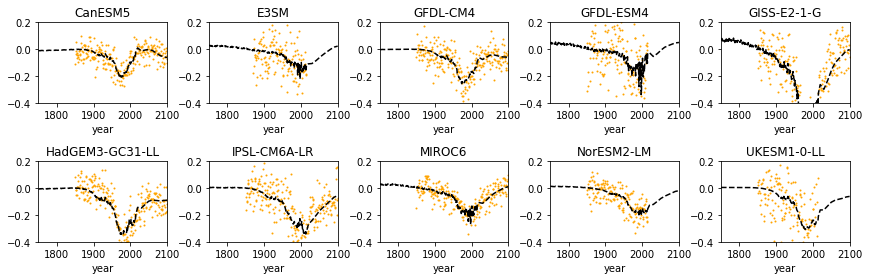

In [5]:
# validate tuning
fig,ax = plt.subplots(2,5,figsize=(12,4))

for i,model in enumerate(CMIP6_aer_forc.columns.levels[0]):
    
    model_forc = CMIP6_aer_forc.loc[:,model]
    model_erfari = (model_forc['aprp_ERFariSW']+model_forc['aprp_ERFariLW']).dropna()
    RCMIP_emms = aer_emms.copy()
    
    FaIRv2_erfari = RCMIP_emms * ERFari_coefs.loc[model,:]
    
    model_erfari.plot(ax=ax.flatten()[i],color='orange',marker='o',lw=0,ms=1)
    FaIRv2_erfari.sum(axis=1).plot(ax=ax.flatten()[i],color='k',ls='--')
    ax.flatten()[i].set_title(model)
    
[a.set_ylim(-0.4,0.2) for a in ax.flatten()]
[a.set_xlim(1750,2100) for a in ax.flatten()]
plt.tight_layout()
''

### ERFari

In [6]:
def fit_aci(x,model):
    
    model_forc = CMIP6_aer_forc.loc[:,model]
    model_erfaci = (model_forc['aprp_ERFaciSW']+model_forc['aprp_ERFaciLW']).dropna()
    emms = aer_emms.loc[model_erfaci.index]
    
    fit = x[0] * np.log(1 + emms['so2'].values / np.exp(x[1]) ) + x[2]*(emms['bc'].values+emms['oc'].values)
    
    return np.sum((fit-model_erfaci)**2)

ERFaci_coefs = pd.DataFrame(index = CMIP6_aer_forc.columns.levels[0],columns =['beta','s','alpha'])

for model in CMIP6_aer_forc.columns.levels[0]:
    fit_so2 = sp.optimize.minimize(fit_aci,x0=[-0.4,np.log(60),0],args=model,method='nelder-mead').x
    fit_so2[1] = np.exp(fit_so2[1])
    
    ERFaci_coefs.loc[model] = fit_so2

''

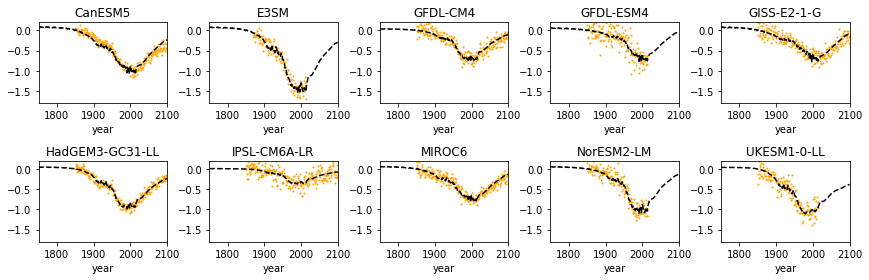

In [7]:
# validate tuning
fig,ax = plt.subplots(2,5,figsize=(12,4))

for i,model in enumerate(CMIP6_aer_forc.columns.levels[0]):
    
    model_forc = CMIP6_aer_forc.loc[:,model]
    model_erfaci = (model_forc['aprp_ERFaciSW']+model_forc['aprp_ERFaciLW']).dropna()
    emms = aer_emms.copy()
    
    FaIRv2_erfaci = ERFaci_coefs.loc[model,'beta'] * np.log(1 + emms['so2'] / ERFaci_coefs.loc[model,'s'] ) + ERFaci_coefs.loc[model,'alpha']*(emms['bc']+emms['oc'])
    
    model_erfaci.plot(ax=ax.flatten()[i],color='orange',marker='o',lw=0,ms=1)
    FaIRv2_erfaci.plot(ax=ax.flatten()[i],color='k',ls='--')
    ax.flatten()[i].set_title(model)
    
[a.set_ylim(-1.8,0.2) for a in ax.flatten()]
[a.set_xlim(1750,2100) for a in ax.flatten()]
plt.tight_layout()
''

## Save coefficients to repo

In [8]:
# ERFaci_coefs.to_csv('../../aux/parameter-sets/CMIP6_ERFaci.csv')
# ERFari_coefs.to_csv('../../aux/parameter-sets/CMIP6_ERFari.csv')

In [9]:
#definition to round to set sfs:
def round_to_sf(x,sf):
    if x==0:
        return 0
    if np.isnan(x):
        return '-'
    else:
        num= round(x, sf - int(np.floor(np.log10(abs(x)))))
        if abs(num)>10**sf:
            return str(int(num))
        else:
            return str(num)

In [10]:
ERFaer_table = pd.concat([
                        ERFari_coefs.rename(dict(so2='$f^{\text{SO}_2}_2$',bc='$f^{\text{BC}}_2$',oc='$f^{\text{OC}}_2$'),axis=1),
                        ERFaci_coefs.rename(dict(beta='$f^{\text{aci}}_1$',s='$C_0^{\text{SO}_2}$',alpha='$f^{\text{aci}}_2$'),axis=1),
                    ],axis=1,keys=['ERFari','ERFaci']).applymap(lambda x:round_to_sf(x,2))

ERFaer_table.index.name='model'
ERFaer_table.columns.names=['source','parameter']
ERFaer_table#.to_latex('../../docs/manuscript/tables/Tab4',escape=False,bold_rows=True)

source                       ERFari                                      \
parameter       $f^{\text{SO}_2}_2$ $f^{\text{BC}}_2$ $f^{\text{OC}}_2$   
model                                                                     
CanESM5                    -0.00249            0.0326         -0.000347   
E3SM                      -0.000942            0.0248           -0.0126   
GFDL-CM4                   -0.00261            0.0269          -0.00209   
GFDL-ESM4                  -0.00264             0.102           -0.0304   
GISS-E2-1-G                -0.00668             0.146           -0.0441   
HadGEM3-GC31-LL            -0.00291           0.00196           0.00415   
IPSL-CM6A-LR              -0.000748           -0.0561           0.00885   
MIROC6                     -0.00178            0.0387           -0.0142   
NorESM2-LM                 -0.00126           0.00302           -0.0034   
UKESM1-0-LL                -0.00239           0.00255          6.32e-05   

source                      ERFaci                                         
parameter       $f^{\text{aci}}_1$ $C_0^{\text{SO}_2}$ $f^{\text{aci}}_2$  
model                                                                      
CanESM5                     -0.387                23.8            -0.0152  
E3SM                         -1.64                 113            -0.0142  
GFDL-CM4                     -2.23                 427           -0.00803  
GFDL-ESM4                    -57.6               17000            -0.0153  
GISS-E2-1-G                 -0.156                16.8            -0.0176  
HadGEM3-GC31-LL             -0.783                66.9           -0.00691  
IPSL-CM6A-LR                -0.951                 306           -0.00173  
MIROC6                      -0.392                46.6            -0.0124  
NorESM2-LM                   -68.6               10300            -0.0123  
UKESM1-0-LL                  -0.74                38.9          -0.000265

## Create plot for the paper

set some matplotlib rcParams

In [11]:
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11

matplotlib.rcParams['axes.formatter.limits']=-3,3

matplotlib.rcParams['legend.frameon']=False

plt.rcParams['pdf.fonttype'] = 42

In [12]:
## aggregate data into good format:
CMIP6_plot_data = []
FaIRfit_plot_data = []

for model in CMIP6_aer_forc.columns.levels[0]:
    
    CMIP6_ERFari = (CMIP6_aer_forc.loc[:,(model,'aprp_ERFariSW')]+CMIP6_aer_forc.loc[:,(model,'aprp_ERFariLW')]).dropna()
    CMIP6_ERFaci = (CMIP6_aer_forc.loc[:,(model,'aprp_ERFaciSW')]+CMIP6_aer_forc.loc[:,(model,'aprp_ERFaciLW')]).dropna()
    CMIP6_tot = CMIP6_ERFari+CMIP6_ERFaci
    
    CMIP6_plot_data+=[pd.concat([CMIP6_ERFari,CMIP6_ERFaci,CMIP6_tot],axis=1,keys=['ERFari','ERFaci','Total'])]
    
    FaIR_ERFaci = ERFaci_coefs.loc[model,'beta'] * np.log(1 + aer_emms['so2'] / ERFaci_coefs.loc[model,'s'] ) + ERFaci_coefs.loc[model,'alpha']*(aer_emms['bc']+aer_emms['oc'])
    FaIR_ERFari = (aer_emms * ERFari_coefs.loc[model,:]).sum(axis=1)
    FaIR_tot = FaIR_ERFaci+FaIR_ERFari
    
    FaIRfit_plot_data+=[pd.concat([FaIR_ERFari,FaIR_ERFaci,FaIR_tot],axis=1,keys=['ERFari','ERFaci','Total'])]
    
    
    
CMIP6_plot_data = pd.concat(CMIP6_plot_data,axis=1,keys=CMIP6_aer_forc.columns.levels[0])
FaIRfit_plot_data = pd.concat(FaIRfit_plot_data,axis=1,keys=CMIP6_aer_forc.columns.levels[0])

plot_data = pd.concat([CMIP6_plot_data,FaIRfit_plot_data],axis=1,keys=['CMIP6','FaIRv2.0.0 fit']).stack(level=[0,1,2]).sort_index().reset_index()
plot_data.columns=['year','source','model','ERF','value']

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


''

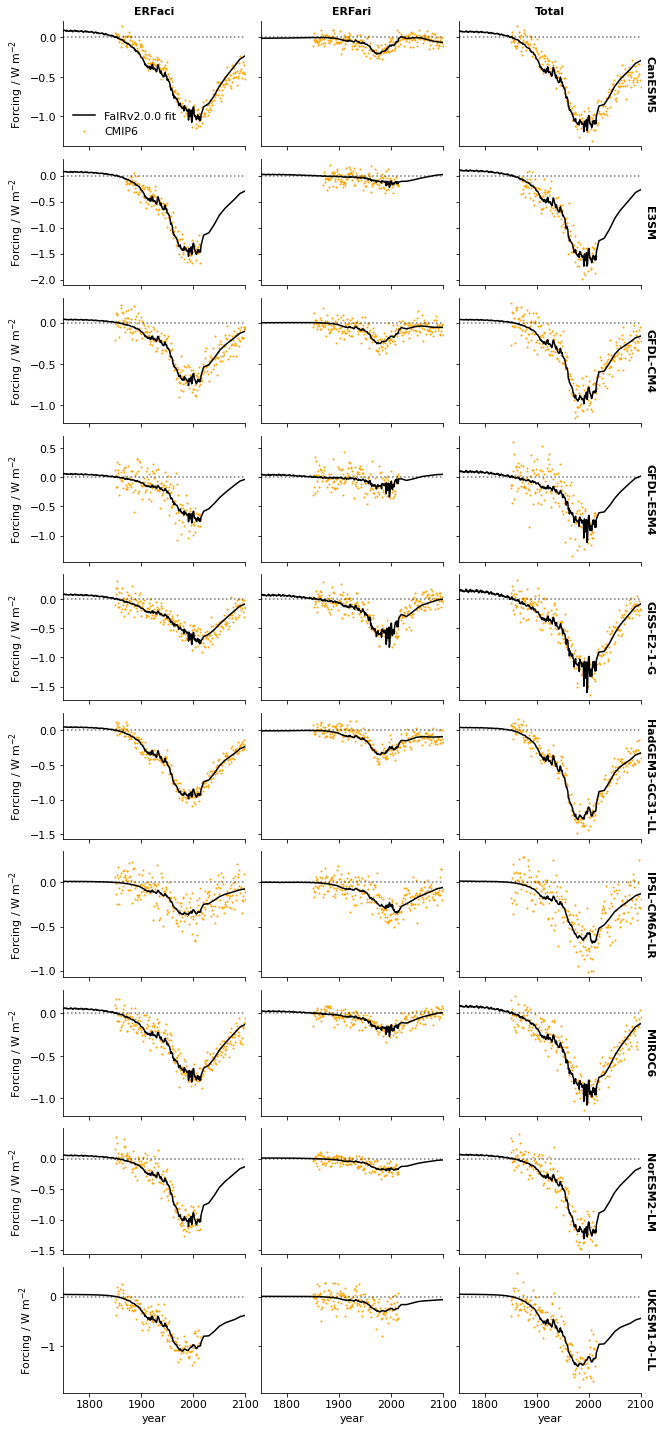

In [13]:
def custom_facet(x,y,**kwargs):
    if kwargs['label']=='FaIRv2.0.0 fit':
        plt.plot(x,y,**kwargs,zorder=10)
    elif kwargs['label']=='CMIP6':
        plt.plot(x,y,**kwargs,marker='.',lw=0,ms=2)
        
        
g= sn.FacetGrid(data=plot_data,
                col='ERF',
                row='model',
                sharey='row',
                hue='source',
                palette=['k','orange'],
                margin_titles=True,
                height=2,
                aspect=1.5
               )

g.map(custom_facet,'year','value')
g.map(plt.axhline,y=0,ls=':',alpha=0.3,color='k')
g.set(xlim=[1750,2100]).set_titles(col_template="{col_name}",fontweight='bold', row_template="{row_name}").set_axis_labels("year", "Forcing / W m$^{-2}$")
g.axes[0,0].legend(*[x[:2] for x in g.axes[0,0].get_legend_handles_labels()])
g.fig.subplots_adjust(hspace=0.1)
[a.ticklabel_format(style='plain') for a in g.axes[-1]]

[g.fig.savefig('../../docs/manuscript/figures/Fig5.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''